Data Preparation

Install libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import ParameterGrid


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
sentiment_dataset = pd.read_csv("/content/drive/MyDrive/semestr 8/Sentiment140_filtered.csv")

In [4]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [5]:
sentiment_dataset.isnull().sum()

,0
Unnamed: 0,0
target,0
ids,0
date,0
flag,0
user,0
text,0
hate_pred,0


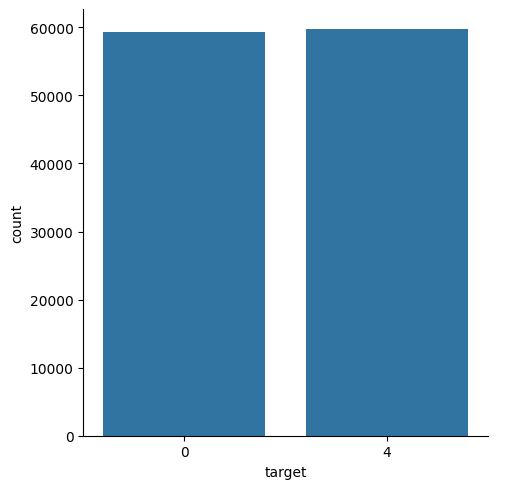

In [6]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [7]:
hateful_dataset = pd.read_csv("/content/drive/MyDrive/semestr 8/hateful_sentiment.csv")

In [8]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [9]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [10]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [11]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0

In [12]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

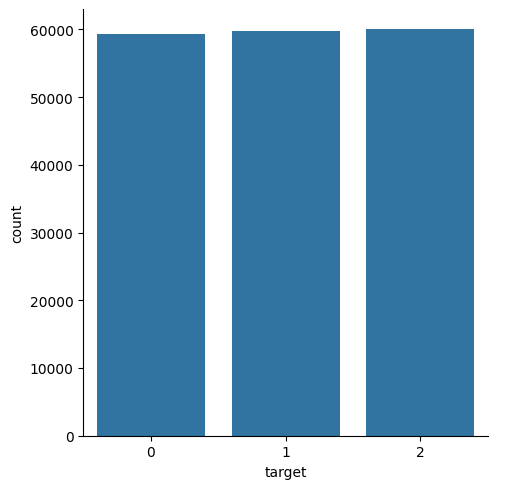

In [13]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [14]:
sentiment_dataset['target'].value_counts()

,count
target,
2,60000
1,59700
0,59300


In [15]:
sentiment_dataset.isnull().sum()

,0
text,0
target,0


# LSTM

In [16]:
# checking the number of unique words to better estimate size of the vocabulary (max_features)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentiment_dataset['text'])
print("Unique words:", len(tokenizer.word_index))

Unique words: 136859


Tokenization

In [17]:
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(sentiment_dataset['text'].values)
X = tokenizer.texts_to_sequences(sentiment_dataset['text'].values)
X = pad_sequences(X)

In [18]:
X = np.array(X)
y = sentiment_dataset['target'].astype(int)
y = to_categorical(y, num_classes=3)

In [19]:
y_integers = np.argmax(y, axis=1)

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Manually specified (non-default) hyperparameters of the model architecture:
- input_dim=10000 - sice of the vocabulary (based on the number of unique words)
- output_dim=200 - length of embeding vector, value 200 is commonly use for the model. It was not tunned because of it low impact on model and to reduce computatino time
- Dense(64, activation='relu') – a dense layer with ReLU activation (it allowes model to lern more complex representatinos)
- Dense(3, activation='softmax') - defining how many class we have
- Nr of epochs - 10

The parameters we will be tuning:
- the number of LSTM units
- dropout - to reduce overfitting



In [21]:
param_grid = list(ParameterGrid({
    'lstm_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
}))

metrics_all = {
    'accuracy': {str(p): [] for p in param_grid},
    'precision': {str(p): [] for p in param_grid},
    'recall': {str(p): [] for p in param_grid},
    'f1': {str(p): [] for p in param_grid}
}

predictions_all = {str(p): {'y_true': [], 'y_pred': []} for p in param_grid}


for params in param_grid:
  p_str = str(params)
  for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_integers)):
      model = Sequential([
      Embedding(input_dim=10000, output_dim=200),
      LSTM(params[ 'lstm_units'], return_sequences=True),
      Dropout(params['dropout_rate']),
      LSTM(params[ 'lstm_units']),
      Dense(64, activation='relu',),
      Dense(3, activation='softmax')


      ])

      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

      X_train, X_val = X[train_idx], X[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]


      model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)



      y_pred_probs = model.predict(X_val)
      y_pred = np.argmax(y_pred_probs, axis=1)
      y_true = np.argmax(y_val, axis=1)

      predictions_all[p_str]['y_true'].extend(y_true)
      predictions_all[p_str]['y_pred'].extend(y_pred)


      acc = accuracy_score(y_true, y_pred)
      prec = precision_score(y_true, y_pred, average='macro')
      rec = recall_score(y_true, y_pred, average='macro')
      f1 = f1_score(y_true, y_pred, average='macro')


      metrics_all['accuracy'][p_str].append(acc)
      metrics_all['precision'][p_str].append(prec)
      metrics_all['recall'][p_str].append(rec)
      metrics_all['f1'][p_str].append(f1)




summary_df = pd.DataFrame({
    'params': list(metrics_all['f1'].keys()),
    'accuracy': [np.mean(metrics_all['accuracy'][p]) for p in metrics_all['accuracy']],
    'precision': [np.mean(metrics_all['precision'][p]) for p in metrics_all['precision']],
    'recall': [np.mean(metrics_all['recall'][p]) for p in metrics_all['recall']],
    'f1': [np.mean(metrics_all['f1'][p]) for p in metrics_all['f1']]
})


print(summary_df.round(4).to_string(index=False))

1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
                                 params  accuracy  precision  recall     f1
{'dropout_rate': 0.3, 'lstm_units': 32}    0.8138     0.813

Statistic test for model tuning

In [22]:
!pip install scikit-posthocs


In [23]:
import scikit_posthocs as sp


best_configs = {}

for metric in metrics_all:
    df = pd.DataFrame(metrics_all[metric])
    means = df.mean().sort_values(ascending=False)
    best_config = means.index[0]
    best_score = means.iloc[0]
    best_configs[metric] = (best_config, best_score)

    print(f"\n {metric.upper()} – mean values:")
    print(means.round(4))

    friedman = sp.posthoc_nemenyi_friedman(df.to_numpy())
    nemenyi_df = pd.DataFrame(friedman, index=df.columns, columns=df.columns)

    print(f"\nTest Friedmana (p-value)  {metric.upper()}:\n")
    print(nemenyi_df.round(4))


best_df = pd.DataFrame([
    {'metric': m, 'best_params': cfg, 'mean_score': round(score, 4)}
    for m, (cfg, score) in best_configs.items()
])

print(best_df.round(4).to_string(index=False))


 ACCURACY – mean values:
{'dropout_rate': 0.5, 'lstm_units': 32}    0.8174
{'dropout_rate': 0.5, 'lstm_units': 64}    0.8161
{'dropout_rate': 0.3, 'lstm_units': 64}    0.8144
{'dropout_rate': 0.3, 'lstm_units': 32}    0.8138
dtype: float64

Test Friedmana (p-value)  ACCURACY:

                                         {'dropout_rate': 0.3, 'lstm_units': 32}  \
{'dropout_rate': 0.3, 'lstm_units': 32}                                      NaN   
{'dropout_rate': 0.3, 'lstm_units': 64}                                      NaN   
{'dropout_rate': 0.5, 'lstm_units': 32}                                      NaN   
{'dropout_rate': 0.5, 'lstm_units': 64}                                      NaN   

                                         {'dropout_rate': 0.3, 'lstm_units': 64}  \
{'dropout_rate': 0.3, 'lstm_units': 32}                                      NaN   
{'dropout_rate': 0.3, 'lstm_units': 64}                                      NaN   
{'dropout_rate': 0.5, 'lstm_units': 32}         

confiusion matrix for best parameters


Confusion Matrix for best ACCURACY configuration:
{'dropout_rate': 0.5, 'lstm_units': 32}



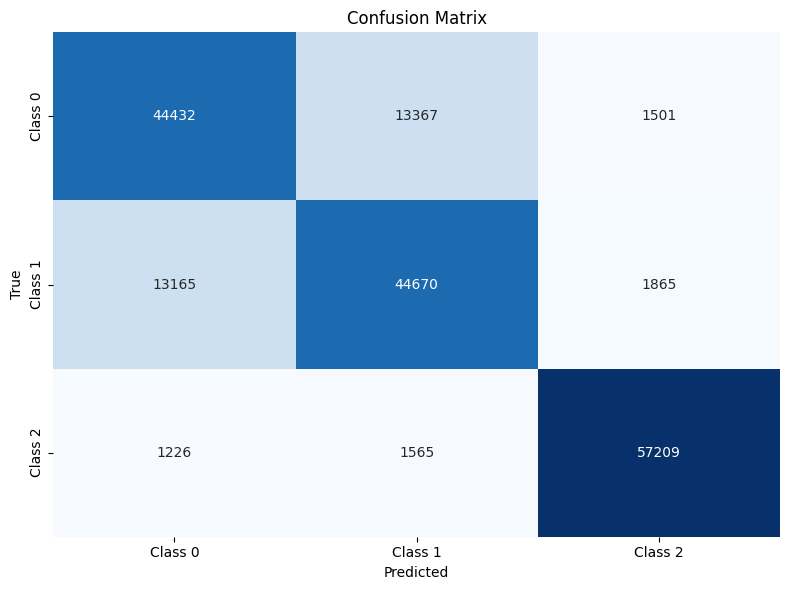


Confusion Matrix for best PRECISION configuration:
{'dropout_rate': 0.5, 'lstm_units': 32}



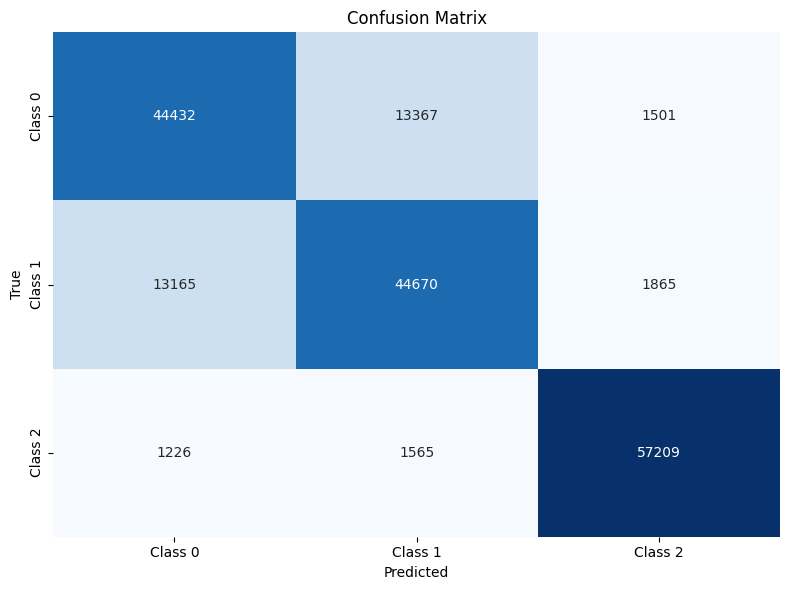


Confusion Matrix for best RECALL configuration:
{'dropout_rate': 0.5, 'lstm_units': 32}



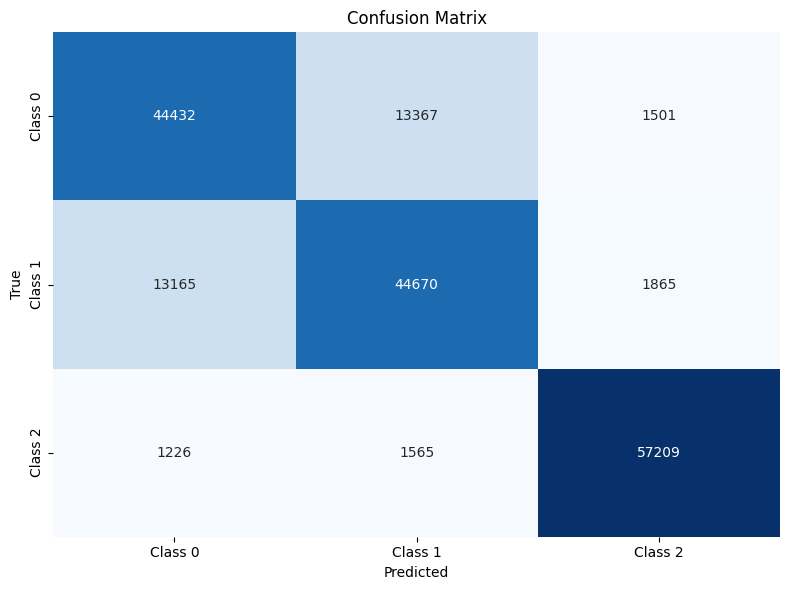


Confusion Matrix for best F1 configuration:
{'dropout_rate': 0.5, 'lstm_units': 32}



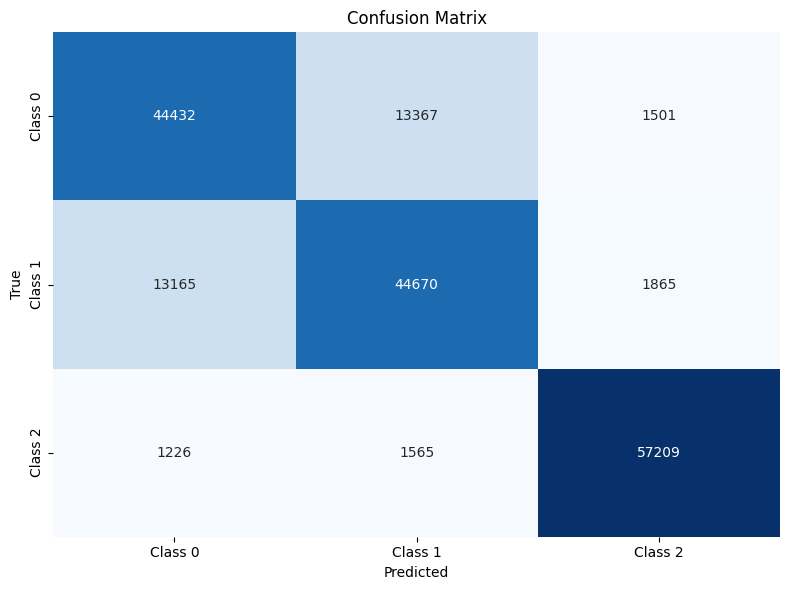

In [24]:
for metric, (best_config_str, _) in best_configs.items():
    preds = predictions_all[best_config_str]
    y_true = preds['y_true']
    y_pred = preds['y_pred']

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nConfusion Matrix for best {metric.upper()} configuration:\n{best_config_str}\n")

    plt.figure(figsize=(8, 6))
    sns.heatmap(
      cm, annot=True, fmt='d', cmap='Blues', cbar=False,
      xticklabels=['Class 0', 'Class 1', 'Class 2'],
      yticklabels=['Class 0', 'Class 1', 'Class 2']
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()



Creating df with the best algorithm parameters (the best f1 score) and the results of metrics for each fold

In [25]:
f1_best_config_str = best_configs['f1'][0]

f1_metrics = {
    'accuracy': metrics_all['accuracy'][f1_best_config_str],
    'precision': metrics_all['precision'][f1_best_config_str],
    'recall': metrics_all['recall'][f1_best_config_str],
    'f1': metrics_all['f1'][f1_best_config_str]
}

# results of the folds
f1_fold_df = pd.DataFrame(f1_metrics)

f1_fold_df.to_csv("lstm_best_model_metrics.csv", index=False)